# Stanford dogs: breed classifier

## 1. Import libraries and define data folders

In [1]:
# basic libraries
import os
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [2]:
# image pretreatment
import matplotlib.pyplot as plt

import cv2
import numpy as np
from PIL import Image
from keras.utils.vis_utils import plot_model
# augmentation
import imageio
import imgaug as ia
from imgaug import augmenters as iaa

In [3]:
# libraries for a CNN
import tensorflow as tf

from keras.models import Sequential
from keras.layers import Conv2D,MaxPooling2D,Dense,Flatten,Dropout
from keras.layers.normalization import BatchNormalization
from keras.layers import GlobalAveragePooling2D
from keras.layers import Dropout, Activation
from keras.optimizers import Adam,SGD,Adagrad,Adadelta,RMSprop
from keras.utils import to_categorical

from tensorflow.python.client import device_lib


import keras
from numpy import expand_dims
from keras import backend as K
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import ImageDataGenerator

In [4]:
# load data
ANNOTATION_DIR = '/media/marco/DATA/OC_Machine_learning/section_6/DATA/Annotation/' 
IMAGES_DIR = '/media/marco/DATA/OC_Machine_learning/section_6/DATA/Images/'

In [5]:
import psutil
from platform import python_version
import multiprocessing as mp
print("py", python_version())
print("tf", tf.__version__)
print("keras", tf.keras.__version__)
mem = psutil.virtual_memory()
print("mem", mem.total/1024/1024)
cpu = mp.cpu_count()
print("cpu", cpu)

%system nvidia-smi
#%system rocm-smi

py 3.7.6
tf 2.2.0
keras 2.3.0-tf
mem 15952.87109375
cpu 8


['Fri Aug  7 13:49:47 2020       ',
 '+-----------------------------------------------------------------------------+',
 '| NVIDIA-SMI 450.51.06    Driver Version: 450.51.06    CUDA Version: 11.0     |',
 '|-------------------------------+----------------------+----------------------+',
 '| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |',
 '| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |',
 '|                               |                      |               MIG M. |',
 '|===============================+======================+======================|',
 '|   0  Quadro K620         On   | 00000000:01:00.0  On |                  N/A |',
 '| 34%   50C    P0     2W /  30W |    259MiB /  1994MiB |      0%      Default |',
 '|                               |                      |                  N/A |',
 '+-------------------------------+----------------------+----------------------+',
 '                                      

### 1.1 Visualize list of breeds (classes) and a sample data (image)

In [6]:
breed_list = os.listdir(IMAGES_DIR)
print("num. breeds total:", len(breed_list))

num. breeds total: 120


In [7]:
filtered_breeds = [breed.split('-',1)[1] for breed in breed_list] #visualize breeds
filtered_breeds[:12]

['Chihuahua',
 'Japanese_spaniel',
 'Maltese_dog',
 'Pekinese',
 'Shih-Tzu',
 'Blenheim_spaniel',
 'papillon',
 'toy_terrier',
 'Rhodesian_ridgeback',
 'Afghan_hound',
 'basset',
 'beagle']

## 1.2 Example equalization 

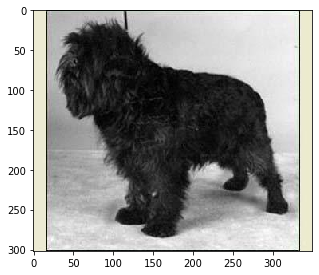

In [18]:
## set the seed for the np.random module, so we always get the same image when run this code cell
np.random.seed(112)

# since we just want one image, I'll ramdomly choose a breed and a dog from that breed
breed = np.random.choice(breed_list)
dog = np.random.choice(os.listdir(ANNOTATION_DIR + breed))

# opening one image
img = cv2.imread(IMAGES_DIR + breed + '/' + dog + '.jpg') 
# this line is necessary because cv2 reads an image in BGR format (Blue, Green, Red) by default. 
# So we will convert it to RGB
img_RGB = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 
img_grayscale = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
img_to_yuv = cv2.cvtColor(img,cv2.COLOR_BGR2YUV)
imgresized = img.resize((227, 227))
plt.figure(figsize = (5,5))
plt.imshow(img_RGB)

image above shows that we have humans together with dogs

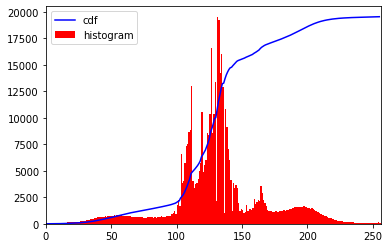

In [10]:
hist,bins = np.histogram(img_to_yuv.flatten(),256,[0,256])
cdf = hist.cumsum()
cdf_normalized = cdf * float(hist.max()) / cdf.max()
plt.plot(cdf_normalized, color = 'b')
plt.hist(img_to_yuv.flatten(),256,[0,256], color = 'r')
plt.xlim([0,256])
plt.legend(('cdf','histogram'), loc = 'upper left')
plt.show()

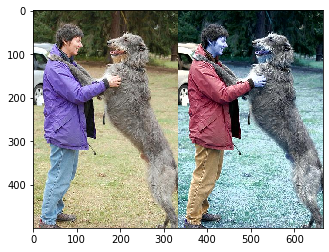

In [16]:
img_to_yuv[:,:,0] = cv2.equalizeHist(img_to_yuv[:,:,0])
equ = cv2.cvtColor(img_to_yuv, cv2.COLOR_YUV2BGR)
res = np.hstack((img_RGB,equ)) #stacking images side-by-side
cv2.imwrite('res.png',res)
plt.imshow(res)

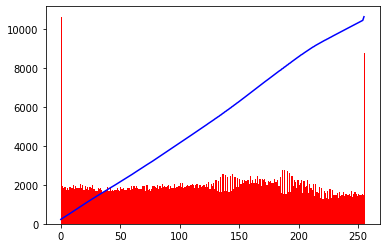

In [12]:
hist,bins = np.histogram(equ.flatten(),256,[0,256])
cdf = hist.cumsum()
cdf_normalized = cdf * float(hist.max()) / cdf.max()
plt.plot(cdf_normalized, color = 'b')
plt.hist(equ.flatten(),256,[0,256], color = 'r')
plt.show()

## 1.3 Example augmentations: mirroring and rotation

Augmented by mirroring:


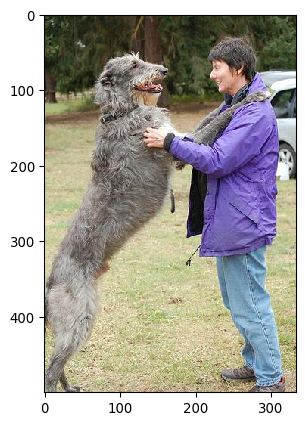

In [13]:
ia.seed(4)

rotate = iaa.Affine(rotate=(-60, 60))
image_aug_1 = rotate(image=img_RGB)
mirror = iaa.Fliplr(0.5)
image_aug_2 = mirror(image=img_RGB)
print("Augmented by mirroring:")
ia.imshow(image_aug_2)

Augmented by rotation:


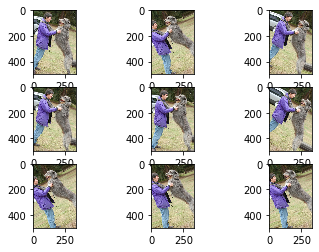

<Figure size 720x720 with 0 Axes>

In [14]:
print("Augmented by rotation:")
#ia.imshow(image_aug_2)
# convert to numpy array
data = img_to_array(img_RGB)

# expand dimension to one sample
samples = expand_dims(data, 0)
# create image data augmentation generator
datagen = ImageDataGenerator(rotation_range=30)
# prepare iterator
it = datagen.flow(samples, batch_size=1)
# generate samples and plot
for i in range(9):
    # define subplot
    plt.subplot(330 + 1 + i)
    # generate batch of images
    batch = it.next()
    # convert to unsigned integers for viewing
    image = batch[0].astype('uint8')
    # plot raw pixel data
    plt.imshow(image)
# show the figure
plt.figure(figsize = (10,10))
plt.show()

## 2. Prepare data for training the CNN model


### 2.1 data loading and image equalization

In [20]:
num_breeds = 15 # integer between 2 and 120
breeds = breed_list[:num_breeds]

def load_images_and_labels(breeds):
    img_lst=[]
    labels=[]
    
    for index, breed in enumerate(breeds):
        for image_name in os.listdir(IMAGES_DIR+"/"+breed):
            img = cv2.imread(IMAGES_DIR+"/"+breed+"/"+image_name)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            
            img_to_yuv[:,:,0] = cv2.equalizeHist(img_to_yuv[:,:,0]) # convert to yuv color space for equalization
            equ = cv2.cvtColor(img_to_yuv, cv2.COLOR_YUV2RGB) # equalize
            
            img_array = Image.fromarray(equ, 'RGB')
            
            #resize image to 227 x 227 because the input image resolution for AlexNet is 227 x 227
            resized_img = img_array.resize((227, 227))
            
            img_lst.append(np.array(resized_img))
            
            labels.append(filtered_breeds[index])
            
    return img_lst, labels 

images, labels = load_images_and_labels(breeds)
print("No. of images loaded = ",len(images),"\nNo. of labels loaded = ",len(labels))

No. of images loaded =  2806 
No. of labels loaded =  2806


### 2.2 label encoding and features normalization

In [ ]:
# replace numbers with names
le = LabelEncoder()
nlabels = le.fit_transform(labels) # encode labels as number values. This prepares for categorical encoding
Y=to_categorical(nlabels,num_classes = num_breeds) # category encoding

In [ ]:
#Normalization for the images
images = np.array(images)
images = images.astype(np.float32)
#labels = labels.astype(np.int32)
X_norm = images/255

### 2.3 test and train sets 

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(X_norm, Y, test_size = 0.2, random_state = 42)

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.1, random_state=1)

print("x_train shape = ",x_train.shape)
print("y_train shape = ",y_train.shape)

print("\nx_val shape = ",x_val.shape)
print("y_val shape = ",y_val.shape)

print("\nx_test shape = ",x_test.shape)
print("y_test shape = ",y_test.shape)

### 2.4 augment the training data.

In [ ]:
# example of training images
df_y_train = pd.DataFrame(y_train, columns = filtered_breeds[:num_breeds]) 
df_given_train = df_y_train.apply(lambda s, n: pd.Series(s.nlargest(n).index), axis=1, n=1)


In [ ]:
plt.figure(figsize = (20,20))
for i in range(5):
    img = x_train[i]
    plt.subplot(1,5,i+1)
    plt.imshow(img)
    #plt.axis("off")
    plt.xlabel(y_train[i], color = "r")
    plt.title(df_given_train.iloc[i,0])
plt.show()

In [ ]:
aug = ImageDataGenerator(rotation_range=30, #rotations (as seen above)
                        width_shift_range=0.2,  # randomly shift images horizontally 
                        height_shift_range=0.2,# randomly shift images vertically 
                        shear_range=0.2, # shear image
                        zoom_range=0.2, # zoom into image 
                        horizontal_flip=True, # randomly flip images horizontally
                        fill_mode='reflect') #  creates a ‘reflection’ and fills the empty values in reverse order of the known values
# fit parameters from data
aug.fit(x_train, augment=True)

## 3. First CNN model (2 convolutional layers only)

### 3.1 define layers

In [21]:
model = Sequential()
# layer 1
model.add(Conv2D(32, (3, 3), use_bias=False, input_shape=(227, 227, 3)))

model.add(Activation("relu"))


# layer 2

model.add(Conv2D(16, (3, 3), use_bias=False))
model.add(MaxPooling2D(pool_size=(4, 4), strides=(4, 4), padding='same'))
model.add(Activation("relu"))
model.add(Flatten())
model.add(Dropout(0.1)) # dropout added

# fully connected layers
model.add(Dense(128, activation='relu'))
model.add(Dense(num_breeds, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 225, 225, 32)      864       
_________________________________________________________________
activation (Activation)      (None, 225, 225, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 223, 223, 16)      4608      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 56, 56, 16)        0         
_________________________________________________________________
activation_1 (Activation)    (None, 56, 56, 16)        0         
_________________________________________________________________
flatten (Flatten)            (None, 50176)             0         
_________________________________________________________________
dropout (Dropout)            (None, 50176)             0

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy']) #compile model
K.set_value(model.optimizer.learning_rate, 0.001)
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

### 3.2 Compile the CNN model

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy']) #compile model
K.set_value(model.optimizer.learning_rate, 0.001)

### 3.3 Fit the model using training data

In [ ]:
%%time
history_1 = model.fit(aug.flow(x_train, y_train), 
          validation_data=(x_val, y_val),
          epochs=25)

In [ ]:
plt.figure(figsize=(18, 6))

plt.subplot(121)
loss = history_1.history['loss']
val_loss = history_1.history['val_loss']
plt.plot(loss,"--", linewidth=3 , label="train")
plt.plot(val_loss, linewidth=3 , label="valid")

plt.legend(['train','validation'], loc='upper left')
plt.grid()
plt.ylabel('loss')
plt.ylim((1.5, 3))
plt.xlabel('Epoch')
plt.title('4 layers CNN Model Loss')
plt.legend(['train','validation'], loc='upper left')

plt.subplot(122)
acc = history_1.history['accuracy']
val_acc = history_1.history['val_accuracy']

plt.plot(acc,"--", linewidth=3 , label="train")
plt.plot(val_acc, linewidth=3 , label="valid")

plt.legend(['train','validation'], loc='upper left')
plt.grid()

plt.ylabel('accuracy')
plt.xlabel('Epoch')
plt.title('4 layers CNN Model accuracy')
plt.legend(['train','validation'], loc='upper left')
plt.show()

In [ ]:
test_loss, test_accuracy = model.evaluate(x_test, y_test)

print("Test results \n Loss:",test_loss,'\n Accuracy',test_accuracy)

## 4. AlexNet

### 4.1 define layers

In [ ]:
# Initializing the CNN
classifier = Sequential()

# Convolution Step 1
classifier.add(Conv2D(96, 11, strides = (4, 4), padding = 'valid', input_shape=(227, 227, 3), activation = 'relu'))

# Max Pooling Step 1
classifier.add(MaxPooling2D(pool_size = (2, 2), strides = (2, 2), padding = 'valid'))
classifier.add(BatchNormalization())

# Convolution Step 2
classifier.add(Conv2D(256, 11, strides = (1, 1), padding='valid', activation = 'relu'))

# Max Pooling Step 2
classifier.add(MaxPooling2D(pool_size = (2, 2), strides = (2, 2), padding='valid'))
classifier.add(BatchNormalization())

# Convolution Step 3
classifier.add(Conv2D(384, 3, strides = (1, 1), padding='valid', activation = 'relu'))
classifier.add(BatchNormalization())

# Convolution Step 4
classifier.add(Conv2D(384, 3, strides = (1, 1), padding='valid', activation = 'relu'))
classifier.add(BatchNormalization())

# Convolution Step 5
classifier.add(Conv2D(256, 3, strides=(1,1), padding='valid', activation = 'relu'))

# Max Pooling Step 3
classifier.add(MaxPooling2D(pool_size = (2, 2), strides = (2, 2), padding = 'valid'))
classifier.add(BatchNormalization())

# Flattening Step
classifier.add(Flatten())

# Full Connection Step
classifier.add(Dense(units = 4096, activation = 'relu'))
classifier.add(Dropout(0.4))
classifier.add(BatchNormalization())
classifier.add(Dense(units = 4096, activation = 'relu'))
classifier.add(Dropout(0.4))
classifier.add(BatchNormalization())
classifier.add(Dense(units = 1000, activation = 'relu'))
classifier.add(Dropout(0.4))
classifier.add(BatchNormalization())
classifier.add(Dense(units = num_breeds, activation = 'softmax'))


### 4.2 compile and run

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
K.set_value(model.optimizer.learning_rate, 0.001)

In [ ]:
#plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
%%time
history_2 = model.fit(aug.flow(x_train, y_train), 
          validation_data=(x_val, y_val),
          epochs=100)
#hist = model.fit(datagen.flow(x_train, y_train), epochs=25)

In [ ]:
## plot the history of loss and accuracy for train and valid data for the Alexnet model
plt.figure(figsize=(18, 6))

plt.subplot(121)
loss = history_2.history['loss']
val_loss = history_2.history['val_loss']
plt.plot(loss,"--", linewidth=3 , label="train")
plt.plot(val_loss, linewidth=3 , label="valid")

plt.legend(['train','validation'], loc='upper left')
plt.grid()
plt.ylabel('loss')
plt.ylim((0, 3))
plt.xlabel('Epoch')
plt.title('Alexnet CNN Model Loss')
plt.legend(['train','validation'], loc='upper left')

plt.subplot(122)
acc = history_2.history['accuracy']
val_acc = history_2.history['val_accuracy']

plt.plot(acc,"--", linewidth=3 , label="train")
plt.plot(val_acc, linewidth=3 , label="valid")

plt.legend(['train','validation'], loc='upper left')
plt.grid()

plt.ylabel('accuracy')
plt.xlabel('Epoch')
plt.title('Alexnet CNN Model accuracy')
plt.legend(['train','validation'], loc='upper left')
plt.show()

In [ ]:
test_loss, test_accuracy = model.evaluate(x_test, y_test)

print(test_loss,test_accuracy)

In [ ]:
pred = model.predict(x_test)
print(y_test.shape)
print(pred.shape)

In [ ]:
roundpred = np.around(pred, decimals=1)
df_pred = pd.DataFrame(roundpred, columns = filtered_breeds[:num_breeds])
df_pred.head()

In [ ]:
df_breed_pred = df_pred.apply(lambda s, n: pd.Series(s.nlargest(n).index), axis=1, n=3)
df_breed_pred.columns = ['1st_prob_breed','2nd_prob_breed','3rd_prob_breed']
df_breed_pred.head()

In [ ]:
prob_df = df_pred.apply(np.sort, axis=1).apply(lambda df_pred: df_pred[-3:]).apply(pd.Series)
prob_df.columns = ['3rd_prob','2nd_prob','1st_prob']
prob_df = prob_df*100
prob_df = prob_df.astype(int)
prob_df = pd.concat([prob_df, df_breed_pred], axis=1)

In [ ]:
prob_df['final']= prob_df["1st_prob_breed"].astype(str) +" "+ prob_df["1st_prob"].astype(str)+"%, "+prob_df["2nd_prob_breed"].astype(str) +" "+ prob_df["2nd_prob"].astype(str)+"%, "+prob_df["3rd_prob_breed"].astype(str) +" "+ prob_df["3rd_prob"].astype(str)+"%"

In [ ]:
df_test = pd.DataFrame(y_test, columns = filtered_breeds[:num_breeds])
given_df = df_test.apply(lambda s, n: pd.Series(s.nlargest(n).index), axis=1, n=1)
given_df.head()


In [ ]:
plt.figure(1 , figsize = (19 , 10))
n = 0 
r = np.random.randint(low=1, high=100, size=9)
for i in r:
    n += 1 
    
    
    plt.subplot(3, 3, n)
    plt.subplots_adjust(hspace = 0.3, wspace = 0.3)
    
    plt.imshow(x_test[i])
    plt.title(given_df.iloc[i,0])
 
    plt.xlabel(prob_df.iloc[i,6], wrap=True, color = "r")
    plt.xticks([]) , plt.yticks([])

plt.show()